# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [487]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [521]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv')

In [663]:
plt.rcParams["figure.figsize"] = (20,8)

In [523]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.shape)
print(feat_info.shape)
print('The values which are missing',feat_info.loc[feat_info.attribute=='AGER_TYP']['missing_or_unknown'].values)
print('Value Counts:',azdias.AGER_TYP.value_counts()) 

(891221, 85)
(85, 4)
The values which are missing ['[-1,0]']
Value Counts: -1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [524]:
# Identify missing or unknown data values and convert them to NaNs.
mis_values=list(feat_info.missing_or_unknown.values)

In [525]:
# Understand the X and XX
cols_x=[]
for ind,val in enumerate(mis_values):
    if 'X' in val:
        cols_x.append(ind+1)
df_x=azdias.iloc[:,cols_x]
mis_col=feat_info.missing_or_unknown[cols_x[0]]
mis_li=mis_col[1:len(mis_col)-1].split(',')
col=df_x.columns[0]
for val in mis_li:
    print('Number of', '*',val.strip(),'*','in column',col,'is',df_x[col].value_counts()[val])

Number of * XX * in column CAMEO_DEU_2015 is 373


In [526]:
# For Other values get the count
for ind in range(azdias.shape[1]):
    df_x=azdias.iloc[:,[ind]]
    mis_col=feat_info.missing_or_unknown[ind]
    col=df_x.columns[0]
    mis_li=mis_col[1:len(mis_col)-1].split(',')
    print('Missing Values for column',col,mis_li)
    for val in mis_li:
        if val not in ['X','XX']:
            if val!='' and int(val) in df_x[col].value_counts():
                print('Number of', '*',val,'*','in column',col,'is',df_x[col].value_counts()[int(val)])
            else:
                print('Number of', '*',val,'*','in column',col,'is',0)
        else:
            if val in  df_x[col].value_counts():
                print('Number of', '*',val,'*','in column',col,'is',df_x[col].value_counts()[val])
            else:
                print('Number of', '*',val,'*','in column',col,'is',0)

Missing Values for column AGER_TYP ['-1', '0']
Number of * -1 * in column AGER_TYP is 677503
Number of * 0 * in column AGER_TYP is 8340
Missing Values for column ALTERSKATEGORIE_GROB ['-1', '0', '9']
Number of * -1 * in column ALTERSKATEGORIE_GROB is 0
Number of * 0 * in column ALTERSKATEGORIE_GROB is 0
Number of * 9 * in column ALTERSKATEGORIE_GROB is 2881
Missing Values for column ANREDE_KZ ['-1', '0']
Number of * -1 * in column ANREDE_KZ is 0
Number of * 0 * in column ANREDE_KZ is 0
Missing Values for column CJT_GESAMTTYP ['0']
Number of * 0 * in column CJT_GESAMTTYP is 0
Missing Values for column FINANZ_MINIMALIST ['-1']
Number of * -1 * in column FINANZ_MINIMALIST is 0
Missing Values for column FINANZ_SPARER ['-1']
Number of * -1 * in column FINANZ_SPARER is 0
Missing Values for column FINANZ_VORSORGER ['-1']
Number of * -1 * in column FINANZ_VORSORGER is 0
Missing Values for column FINANZ_ANLEGER ['-1']
Number of * -1 * in column FINANZ_ANLEGER is 0
Missing Values for column FINA

Missing Values for column PLZ8_ANTG1 ['-1']
Number of * -1 * in column PLZ8_ANTG1 is 0
Missing Values for column PLZ8_ANTG2 ['-1']
Number of * -1 * in column PLZ8_ANTG2 is 0
Missing Values for column PLZ8_ANTG3 ['-1']
Number of * -1 * in column PLZ8_ANTG3 is 0
Missing Values for column PLZ8_ANTG4 ['-1']
Number of * -1 * in column PLZ8_ANTG4 is 0
Missing Values for column PLZ8_BAUMAX ['-1', '0']
Number of * -1 * in column PLZ8_BAUMAX is 0
Number of * 0 * in column PLZ8_BAUMAX is 0
Missing Values for column PLZ8_HHZ ['-1']
Number of * -1 * in column PLZ8_HHZ is 0
Missing Values for column PLZ8_GBZ ['-1']
Number of * -1 * in column PLZ8_GBZ is 0
Missing Values for column ARBEIT ['-1', '9']
Number of * -1 * in column ARBEIT is 0
Number of * 9 * in column ARBEIT is 159
Missing Values for column ORTSGR_KLS9 ['-1', '0']
Number of * -1 * in column ORTSGR_KLS9 is 0
Number of * 0 * in column ORTSGR_KLS9 is 58
Missing Values for column RELAT_AB ['-1', '9']
Number of * -1 * in column RELAT_AB is 0

In [527]:
# Convert those missing values to NaN's
for ind in range(azdias.shape[1]):
    mis_col=feat_info.missing_or_unknown[ind]
    col=azdias.columns[ind]
    mis_li=mis_col[1:len(mis_col)-1].split(',')
    for val in mis_li:
        if val not in ['X','XX']:
            if val!='' and int(val) in azdias[col].value_counts():
                azdias[col]=azdias[col].replace(int(val),np.nan)
        else:
            azdias[col]=azdias[col].replace(val,np.nan)

In [528]:
# Check Again Now it should be 0
for ind in range(azdias.shape[1]):
    df_x=azdias.iloc[:,[ind]]
    mis_col=feat_info.missing_or_unknown[ind]
    col=df_x.columns[0]
    mis_li=mis_col[1:len(mis_col)-1].split(',')
    print('Missing Values for column',col,mis_li)
    for val in mis_li:
        if val not in ['X','XX']:
            if val!='' and int(val) in df_x[col].value_counts():
                print('Number of', '*',val,'*','in column',col,'is',df_x[col].value_counts()[int(val)])
            else:
                print('Number of', '*',val,'*','in column',col,'is',0)
        else:
            if val in  df_x[col].value_counts():
                print('Number of', '*',val,'*','in column',col,'is',df_x[col].value_counts()[val])
            else:
                print('Number of', '*',val,'*','in column',col,'is',0)

Missing Values for column AGER_TYP ['-1', '0']
Number of * -1 * in column AGER_TYP is 0
Number of * 0 * in column AGER_TYP is 0
Missing Values for column ALTERSKATEGORIE_GROB ['-1', '0', '9']
Number of * -1 * in column ALTERSKATEGORIE_GROB is 0
Number of * 0 * in column ALTERSKATEGORIE_GROB is 0
Number of * 9 * in column ALTERSKATEGORIE_GROB is 0
Missing Values for column ANREDE_KZ ['-1', '0']
Number of * -1 * in column ANREDE_KZ is 0
Number of * 0 * in column ANREDE_KZ is 0
Missing Values for column CJT_GESAMTTYP ['0']
Number of * 0 * in column CJT_GESAMTTYP is 0
Missing Values for column FINANZ_MINIMALIST ['-1']
Number of * -1 * in column FINANZ_MINIMALIST is 0
Missing Values for column FINANZ_SPARER ['-1']
Number of * -1 * in column FINANZ_SPARER is 0
Missing Values for column FINANZ_VORSORGER ['-1']
Number of * -1 * in column FINANZ_VORSORGER is 0
Missing Values for column FINANZ_ANLEGER ['-1']
Number of * -1 * in column FINANZ_ANLEGER is 0
Missing Values for column FINANZ_UNAUFFAE

Number of * -1 * in column PLZ8_ANTG2 is 0
Missing Values for column PLZ8_ANTG3 ['-1']
Number of * -1 * in column PLZ8_ANTG3 is 0
Missing Values for column PLZ8_ANTG4 ['-1']
Number of * -1 * in column PLZ8_ANTG4 is 0
Missing Values for column PLZ8_BAUMAX ['-1', '0']
Number of * -1 * in column PLZ8_BAUMAX is 0
Number of * 0 * in column PLZ8_BAUMAX is 0
Missing Values for column PLZ8_HHZ ['-1']
Number of * -1 * in column PLZ8_HHZ is 0
Missing Values for column PLZ8_GBZ ['-1']
Number of * -1 * in column PLZ8_GBZ is 0
Missing Values for column ARBEIT ['-1', '9']
Number of * -1 * in column ARBEIT is 0
Number of * 9 * in column ARBEIT is 0
Missing Values for column ORTSGR_KLS9 ['-1', '0']
Number of * -1 * in column ORTSGR_KLS9 is 0
Number of * 0 * in column ORTSGR_KLS9 is 0
Missing Values for column RELAT_AB ['-1', '9']
Number of * -1 * in column RELAT_AB is 0
Number of * 9 * in column RELAT_AB is 0


In [529]:
# Check whether it is replaced with NaN
azdias.AGER_TYP.value_counts(dropna=False)
# No [-1,0] we preprocessed it

NaN     685843
 2.0     98472
 1.0     79802
 3.0     27104
Name: AGER_TYP, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([32.,  7., 31.,  9.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
         65,  70,  75,  80,  85,  90,  95, 100]),
 <a list of 20 Patch objects>)

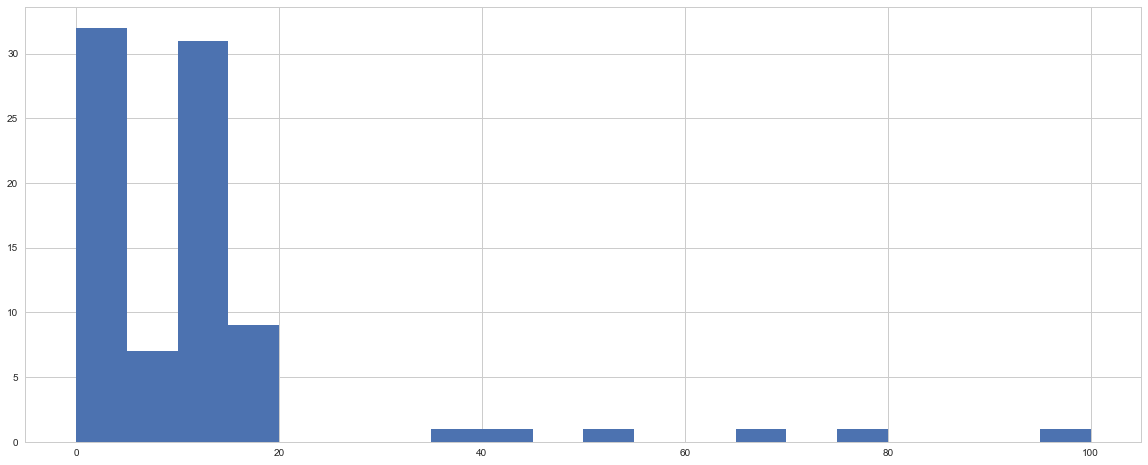

In [664]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
count_nan=azdias.isnull().sum(axis = 0).values
# Normalize values to percentages
total_row=azdias.shape[0]
count_nan=[round(val*100/total_row) for val in count_nan]
bins=np.arange(0,100+5,5)
plt.hist(count_nan,bins=bins)

In [531]:
# Investigate patterns in the amount of missing data in each column.
pd.DataFrame({'val':count_nan}).describe()    
# 75 percent of the columns have 13 or less percent of null values

,val
count,85.000000
mean,11.058824
std,16.460163
min,0.000000
25%,0.000000
50%,10.000000
75%,13.000000
max,100.000000


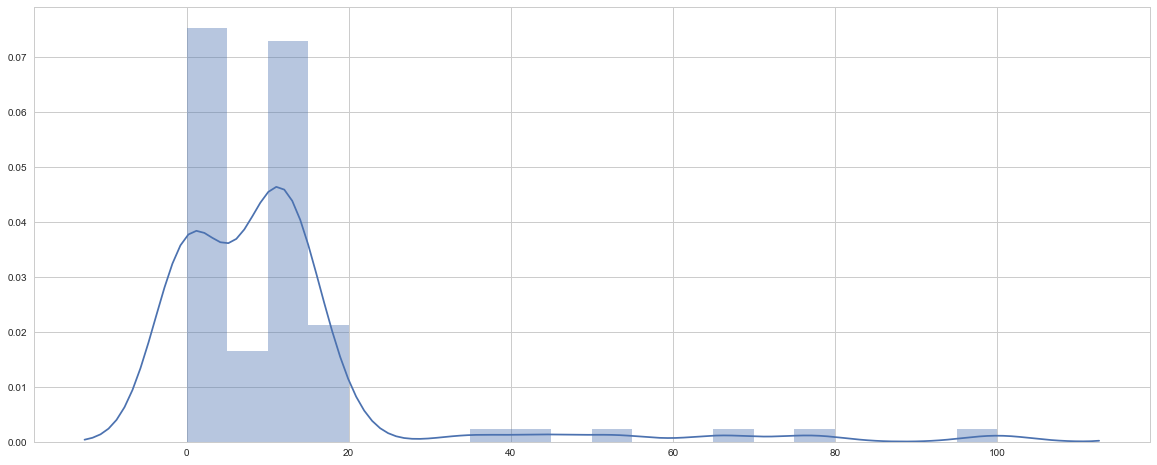

In [665]:
sns.distplot(count_nan,bins = bins)

In [533]:
pat_dict={}
for ind,val in enumerate(count_nan):
    if val in pat_dict:
        pat_dict[val].append(ind)
    else:
        pat_dict[val]=[]
        pat_dict[val].append(ind)

In [534]:
for ind,val in pat_dict.items():
    if ind==0 or ind>20:
        pass
    elif len(val)>=2:
        print('The columns',val,'have null values of percentage',ind)

The columns [3, 12, 19, 20, 23, 72] have null values of percentage 1.0
The columns [14, 21, 22, 38, 41, 74] have null values of percentage 12.0
The columns [15, 16, 50, 51, 57, 58, 59, 66, 67, 68, 82, 83, 84] have null values of percentage 11.0
The columns [17, 18] have null values of percentage 9.0
The columns [39, 44, 45, 49, 53] have null values of percentage 8.0
The columns [52, 54, 55, 56, 69] have null values of percentage 10.0
The columns [60, 61, 62, 63, 65, 71] have null values of percentage 15.0
The columns [70, 73] have null values of percentage 18.0
The columns [75, 76, 77, 78, 79, 80, 81] have null values of percentage 13.0


In [535]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
#Get the columns which have more than 20 % of missing data
dropped_columns=[]
for ind,val in enumerate(count_nan):
    if val>20:
        dropped_columns.append(ind)
azdias_drop=azdias
azdias_drop_columns=list(azdias_drop.columns[dropped_columns])
azdias_drop=azdias_drop.drop(azdias_drop_columns,axis=1)

#### Discussion 1.1.2: Assess Missing Data in Each Column


Most columns have some amount of missing data, but most below 20%. 
* TITEL_KZ, AGER_TYP, KK_KUNDENTYP, KBA05_BAUMAX, GEBURTSJAHR, ALTER_HH have been removed because they have more than 20% of data missing.

* The FINANZ_ and SEMIO_ feature sets are both complete, lacking any missing values.
* The CAMEO_ / RR4-level features have 11% missing values.
* The KBA05_[60,61,62,63] features all have 15.0% missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. Make sure you report your observations in the discussion section. **Either way, you should continue your analysis below using just the subset of the data with few or no missing values.**

In [536]:
# How much data is missing in each row of the dataset?
count_nan_row=azdias_drop.isnull().sum(axis = 1).values 

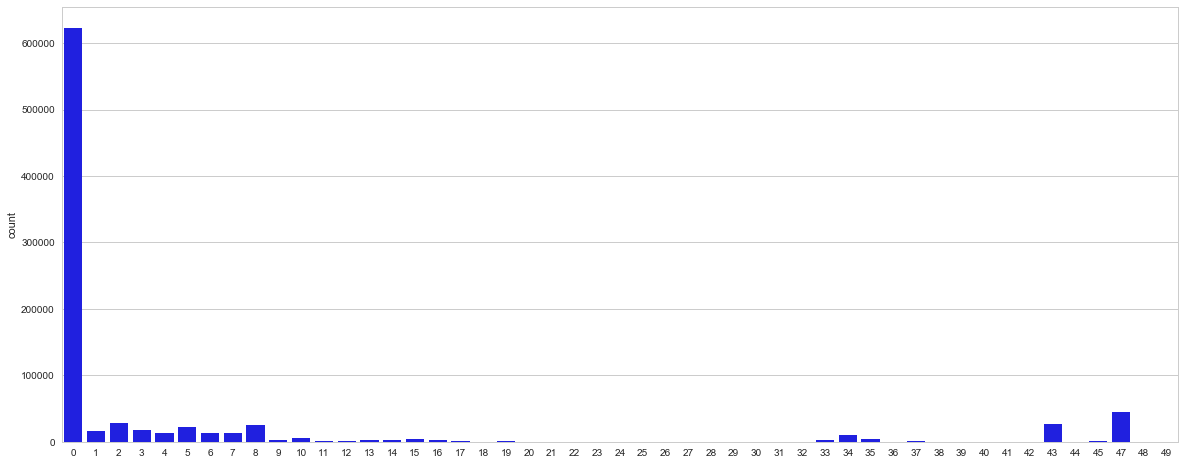

In [666]:
sns.countplot(count_nan_row,color='blue')

In [538]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Threshold value to be <20 as most of the data falling here, let us take 15
azdias_drop_sub1=azdias_drop.loc[count_nan_row<=15]
azdias_drop_sub2=azdias_drop.loc[count_nan_row>15]

In [539]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
count_nan_sub1_col=azdias_drop_sub1.isnull().sum(axis = 0).values 
print(count_nan_sub1_col)
count_nan_sub2_col=azdias_drop_sub2.isnull().sum(axis = 0).values
print(count_nan_sub2_col)

[ 2740     0  4368     0     0     0     0     0     0     0  4368     0
 35855 48801 46001 30511 30511  4368  4368 33115 27615  4368     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
 35855     0 35855     0     0     0     0 58049     0  6180  3598     0
    56     0     0     0  4316  4316  4316 34663 34663 34663 34663 34663
   569   569   569     5 60366 34663  4368 60366  8377 17953 17953 17953
 17953 17953 17953 17953  4165  4071  4165]
[  141     0   486     0     0     0     0     0     0     0   486     0
 75341 48831 48571 47281 47281   486   486 75200 80549   486     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
 75341 73499 75341     0 73499 73499 18348 89939 73499 93431 93410 93148
 73913 93148 93148 93148 95036 95036 95036 98661 98661 98661 98661 98661
 93171 93171 93171 93150 97698 98661   486 97698 97423 98562 98562 98562
 98562 98562 98562 98562 93210 93203 93210]


In [540]:
# Taking 3,4,5,6,7
res_col=[3,4,5,6,7]
azdias_drop_sub1_plot=azdias_drop_sub1.iloc[:,res_col]
azdias_drop_sub2_plot=azdias_drop_sub2.iloc[:,res_col]

In [541]:
def subset_plot(ind):
    st_title='For the Column '+str(azdias_drop_sub1_plot.columns[ind-1])+' the distribution between two subsets'
    plt.suptitle(st_title)
    plt.subplot(121)
    sns.countplot(azdias_drop_sub1_plot.iloc[:,ind-1].values,color='blue')
    plt.subplot(122)
    sns.countplot(azdias_drop_sub2_plot.iloc[:,ind-1].values,color='blue')

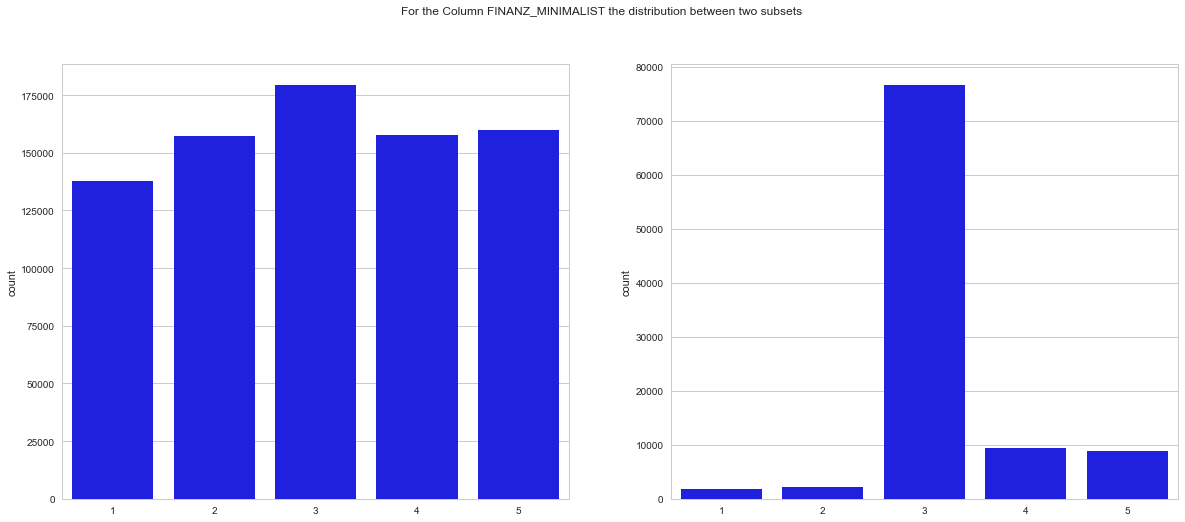

In [667]:
subset_plot(1)

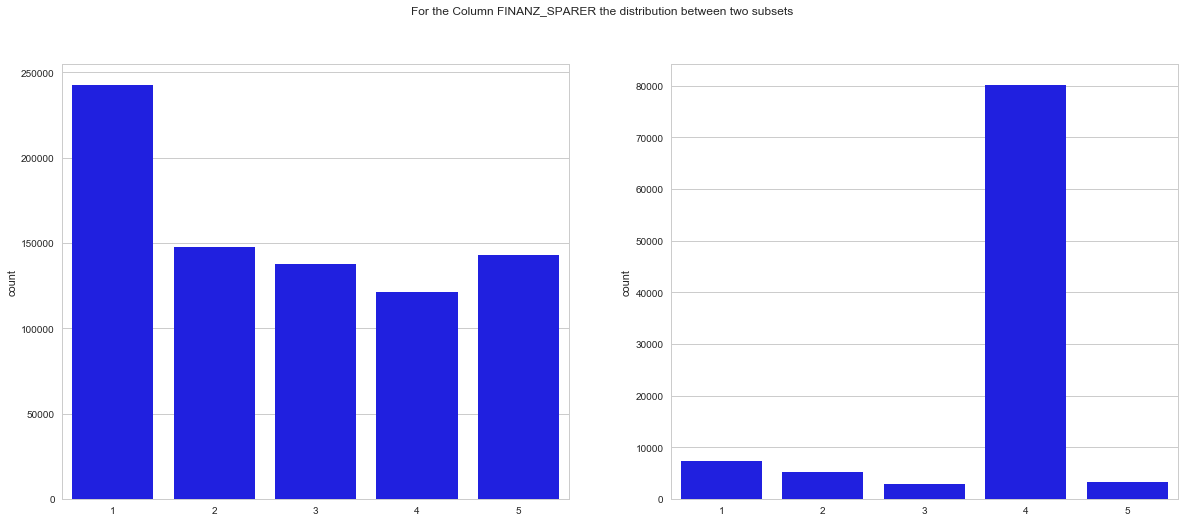

In [668]:
subset_plot(2)

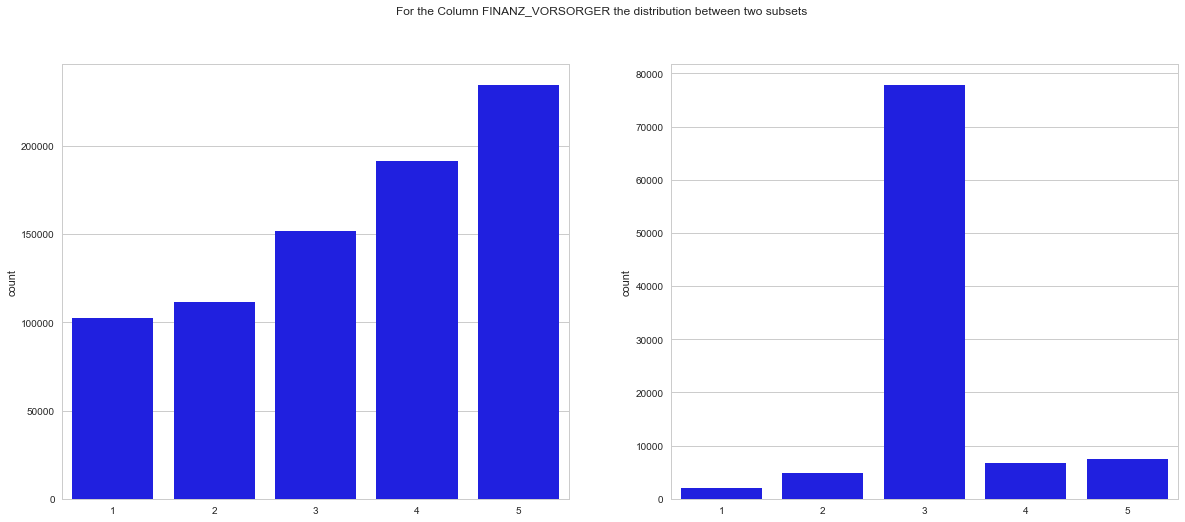

In [669]:
subset_plot(3)

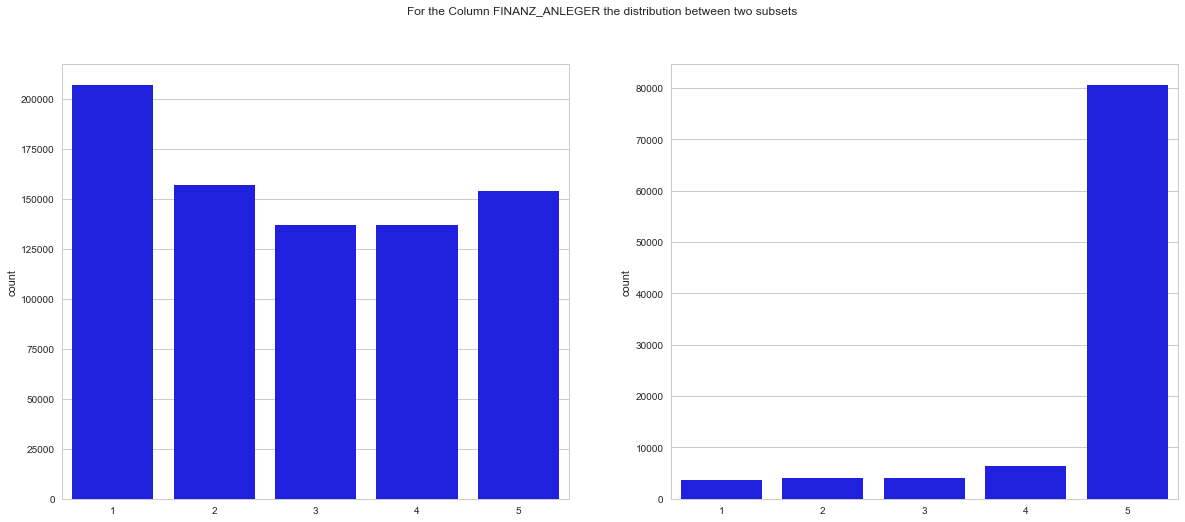

In [670]:
subset_plot(4)

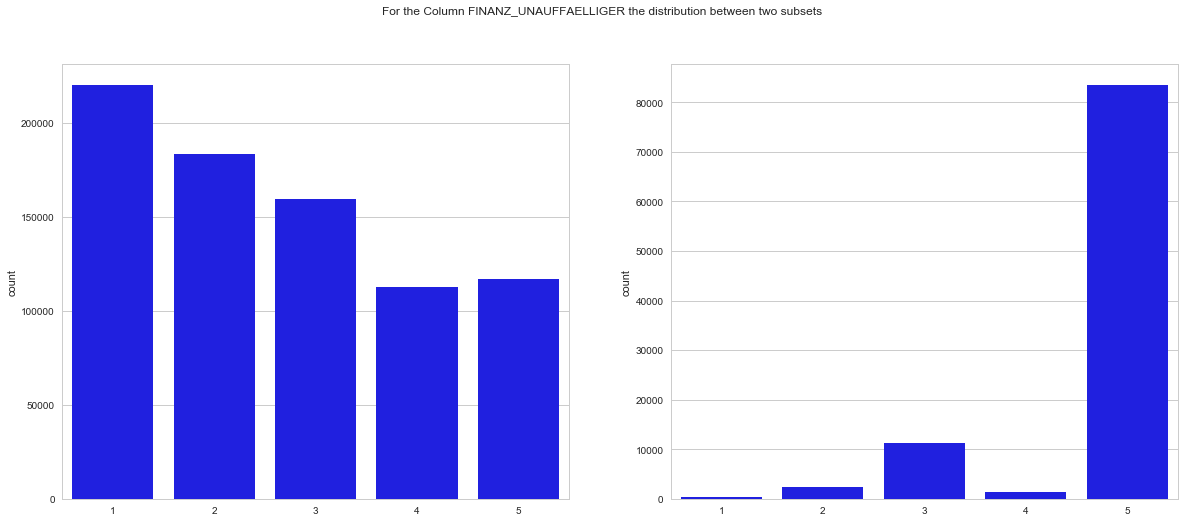

In [671]:
subset_plot(5)

#### Discussion 1.1.3: Assess Missing Data in Each Row

* Yes, two subsets are qualitatively different from one another as we can see in plots, So I think first one has a distribution which is completely different from second one
* Most data points are relatively complete, there are few <30% are having missing values in rows

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [547]:
# How many features are there of each data type?
type_dict={}
col_types=[]
for col in azdias_drop_sub1.columns.values:
    col_type=feat_info.loc[feat_info['attribute']==col]['type'].values[0]
    col_types.append(col_type)
    if col_type in type_dict:
        type_dict[col_type]+=1
    else:
        type_dict[col_type]=1
type_dict

{'categorical': 18, 'mixed': 6, 'numeric': 6, 'ordinal': 49}

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [548]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
binary=[]
multi=[]
for ind,col in enumerate(col_types):
    if col=='categorical':
        count=azdias_drop_sub1.iloc[:,ind].value_counts().count()
        if count==2:
            binary.append(azdias_drop_sub1.columns.values[ind])
        else:
            multi.append(azdias_drop_sub1.columns.values[ind])
binary

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [549]:
for col in binary:
    print(azdias_drop_sub1[col].value_counts())

2    413088
1    379199
Name: ANREDE_KZ, dtype: int64
0    618002
1    174285
Name: GREEN_AVANTGARDE, dtype: int64
0.0    785624
1.0      6663
Name: SOHO_KZ, dtype: int64
2.0    393160
1.0    363272
Name: VERS_TYP, dtype: int64
W    624737
O    167550
Name: OST_WEST_KZ, dtype: int64


In [550]:
azdias_drop_sub1['OST_WEST_KZ']=azdias_drop_sub1['OST_WEST_KZ'].replace('O',0)
azdias_drop_sub1['OST_WEST_KZ']=azdias_drop_sub1['OST_WEST_KZ'].replace('W',1)
azdias_drop_sub1['OST_WEST_KZ'].value_counts()

C:\Users\TsalikiK\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\TsalikiK\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1    624737
0    167550
Name: OST_WEST_KZ, dtype: int64

In [551]:
cols_need_enc=multi
len(cols_need_enc)

13

In [552]:
# Re-encode categorical variable(s) to be kept in the analysis.
enc = OneHotEncoder()
azdias_drop_one_hot=azdias_drop_sub1
azdias_drop_one_hot=pd.get_dummies(azdias_drop_one_hot, columns=cols_need_enc)
len(azdias_drop_one_hot.columns)

194

#### Discussion 1.2.1: Re-Encode Categorical Features

* As we know categorical variables can be binary or multiple I got 5 binary variable and 13 muti categorical variables. I have done one hot encoding like creating dummies for muti categorical variables.
* After doing one hot encoding we can drop the actual variables because we have dummies for that.
* I have got 194 variables after doing one hot encoding on top of that.
* There is variable OST_WEST_KZ which is binary but coded has been converted to binary

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [553]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
mainstream_values=[1,3,5,8,10,12,14]
avantgarde_values=[2,4,6,7,9,11,13,15]
mainstream_col=[]
for val in azdias_drop_one_hot['PRAEGENDE_JUGENDJAHRE'].values:
    if val in mainstream_values:
        mainstream_col.append(1)
    elif val in avantgarde_values:
        mainstream_col.append(0)
    else:
        mainstream_col.append(np.nan)
azdias_drop_one_hot['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=mainstream_col
interval=[]
interval_col=[[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,15]] #Coressponding Intervals(40-50,50-60,60-70,70-80,80-90,90-100)
for valu in azdias_drop_one_hot['PRAEGENDE_JUGENDJAHRE'].values:
    flag=0
    for ind,val in enumerate(interval_col):
        if valu in val:
            interval.append(ind+1)
            flag=1
    if flag==0:
        interval.append(np.nan)
print(len(interval))
print(azdias_drop_one_hot.shape[0])
azdias_drop_one_hot['PRAEGENDE_JUGENDJAHRE_INTERVAL']=interval 

792287
792287


In [554]:
azdias_drop_one_hot['CAMEO_INTL_2015_STATUS']=[int(val)%10 if not np.isnan(float(val)) else np.nan for val in azdias_drop_one_hot['CAMEO_INTL_2015'].values]

In [555]:
azdias_drop_one_hot['CAMEO_INTL_2015_WEALTH']=[int(val)//10 if not np.isnan(float(val)) else np.nan for val in azdias_drop_one_hot['CAMEO_INTL_2015'].values]

#### Discussion 1.2.2: Select and Re-Encode Features

* For PRAEGENDE_JUGENDJAHRE I have done two steps here one for creating extra binary variable for mainstream. One more for creating extra variable for interval.
* For CAMEO_INTL_2015 created extra two variable for status and wealth.
* For LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB these variables can be mapped from LP_Status(from manual observation), So I removed these two variables
* For WOHNLAGE values were inconsistent even though it seems ordinal but there some missing values in between
* For PLZ8_BAUMAX values were analogous to KBA05_BAUMAX as we can derive from them, I dropped it

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [556]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
azdias_drop_one_hot=azdias_drop_one_hot.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1)

In [557]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_drop_one_hot=azdias_drop_one_hot.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],axis=1)
print('Total no of columns after one hot encoding and removing unwanted columns are',azdias_drop_one_hot.shape[1])

Total no of columns after one hot encoding and removing unwanted columns are 192


In [558]:
azdias_drop_one_hot.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'PRAEGENDE_JUGENDJAHRE_INTERVAL',
       'CAMEO_INTL_2015_STATUS', 'CAMEO_INTL_2015_WEALTH'],
      dtype='object', length=192)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [606]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ind in range(df.shape[1]):
        mis_col=feat_info.missing_or_unknown[ind]
        col=df.columns[ind]
        mis_li=mis_col[1:len(mis_col)-1].split(',')
        for val in mis_li:
            if val not in ['X','XX']:
                if val!='' and int(val) in df[col].value_counts():
                    df[col]=df[col].replace(int(val),np.nan)
            else:
                df[col]=df[col].replace(val,np.nan)
    # remove selected columns and rows, ...
    df_drop=df
    df_drop=df_drop.drop(azdias_drop_columns,axis=1)
    count_nan_row=df_drop.isnull().sum(axis = 1).values
    df_drop_sub1=df_drop.loc[count_nan_row<=15]
    df_drop_sub2=df_drop.loc[count_nan_row>15]
    # select, re-encode, and engineer column values.
    df_drop_sub1['OST_WEST_KZ']=df_drop_sub1['OST_WEST_KZ'].replace('O',0)
    df_drop_sub1['OST_WEST_KZ']=df_drop_sub1['OST_WEST_KZ'].replace('W',1)
    df_drop_one_hot=df_drop_sub1
    df_drop_one_hot=pd.get_dummies(df_drop_one_hot, columns=multi)
    mainstream_values=[1,3,5,8,10,12,14]
    avantgarde_values=[2,4,6,7,9,11,13,15]
    mainstream_col=[]
    for val in df_drop_one_hot['PRAEGENDE_JUGENDJAHRE'].values:
        if val in mainstream_values:
            mainstream_col.append(1)
        elif val in avantgarde_values:
            mainstream_col.append(0)
        else:
            mainstream_col.append(np.nan)
    df_drop_one_hot['PRAEGENDE_JUGENDJAHRE_MOVEMENT']=mainstream_col
    interval=[]
    interval_col=[[1,2],[3,4],[5,6,7],[8,9],[10,11,12,13],[14,15]] #Coressponding Intervals(40-50,50-60,60-70,70-80,80-90,90-100)
    for valu in df_drop_one_hot['PRAEGENDE_JUGENDJAHRE'].values:
        flag=0
        for ind,val in enumerate(interval_col):
            if valu in val:
                interval.append(ind+1)
                flag=1
        if flag==0:
            interval.append(np.nan)
    df_drop_one_hot['PRAEGENDE_JUGENDJAHRE_INTERVAL']=interval 
    df_drop_one_hot['CAMEO_INTL_2015_STATUS']=[int(val)%10 if not np.isnan(float(val)) else np.nan for val in df_drop_one_hot['CAMEO_INTL_2015'].values]
    df_drop_one_hot['CAMEO_INTL_2015_WEALTH']=[int(val)//10 if not np.isnan(float(val)) else np.nan for val in df_drop_one_hot['CAMEO_INTL_2015'].values]
    df_drop_one_hot=df_drop_one_hot.drop(['LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'],axis=1)
    df_drop_one_hot=df_drop_one_hot.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1)
    # Return the cleaned dataframe.
    return df_drop_one_hot

In [607]:
print('Before:',customers.shape)
print('After:',clean_data(customers).shape)

Before: (191652, 85)


C:\Users\TsalikiK\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\TsalikiK\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


After: (140898, 191)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values before applying your scaler. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [324]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn import preprocessing
imputer=preprocessing.Imputer(missing_values='NaN',strategy='median',axis=0)
scaler = preprocessing.StandardScaler()
imputed_data=imputer.fit_transform(azdias_drop_one_hot)

In [335]:
# Apply feature scaling to the general population demographics data.
scaled = scaler.fit_transform(imputed_data) 
scaled_df=pd.DataFrame(scaled, columns=list(azdias_drop_one_hot.columns))

### Discussion 2.1: Apply Feature Scaling

* Here as we have some rows with missing values fit the imputer with non missing values and transform null values with the fit model using fit_transform.



* I have also used scaling(normalizaion) for the values which has larger numeric values, so those large values will not effect model by adding some importance.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [361]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA(n_components=96)
principalComponents = pca.fit_transform(scaled)

In [362]:
# Investigate the variance accounted for by each principal component.
variances=[val/100 for val in pca.explained_variance_]
cummilative_variances=np.cumsum(np.round(variances, decimals=3))

<Container object of 25 artists>

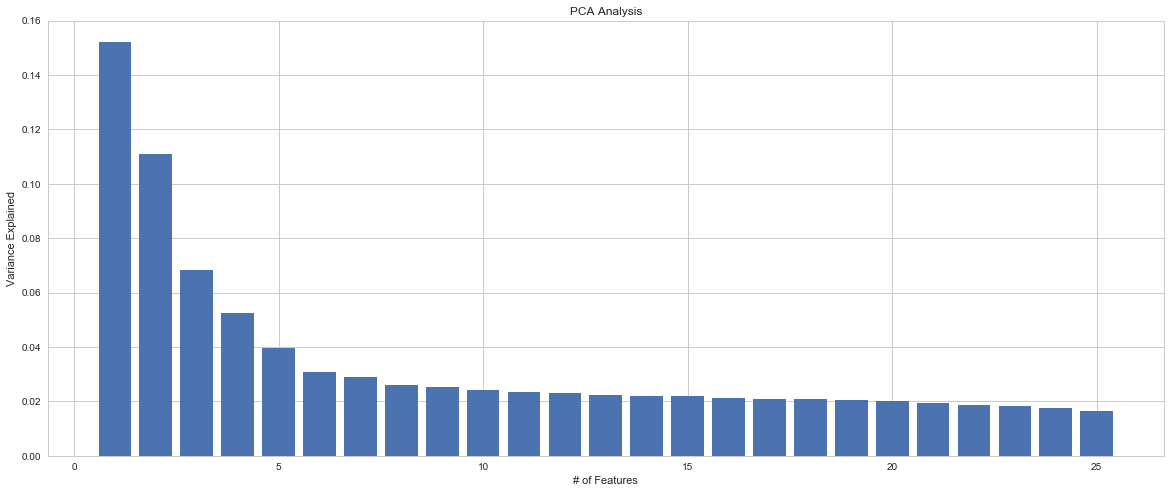

In [672]:
plt.ylabel('Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.bar(range(1,26),variances[:25])

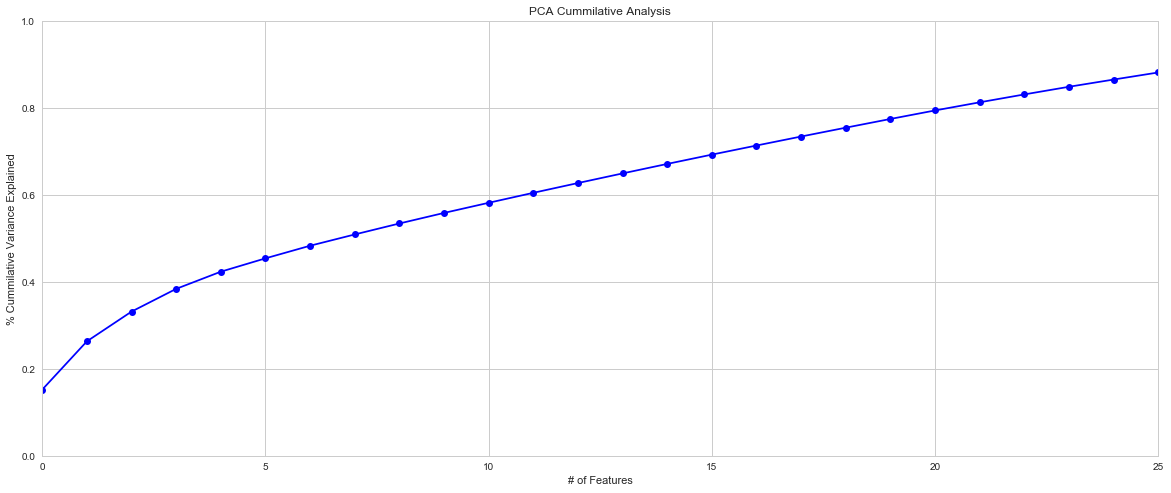

In [673]:
plt.ylabel('% Cummilative Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Cummilative Analysis')
plt.ylim(0,1,0.2)
plt.xlim(0,25,1)
plt.style.context('seaborn-whitegrid')
plt.plot(cummilative_variances,marker='o', color='b')

In [678]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=10)
principalComponents_updated = pca.fit_transform(scaled)

### Discussion 2.2: Perform Dimensionality Reduction

* Hi, I have done dimensionality reduction by getting `explained ratio` of principal components, As i observed 10 components/ eigen values were sufficient to explain more 60% variance in data so I opted that out. I can increase the value to 20 so that I can capture 80% variance of this data but I felt it would be overfitting.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [697]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
first_comp=pca.components_[0]
first_comp_sorted=sorted(first_comp,reverse=True)
first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])

In [698]:
cols_sorted=scaled_df.columns[first_comp_index]
positive_index=first_comp_index[:10]
negative_index=first_comp_index[-10:]
positive_cols=cols_sorted[:10]
negative_cols=cols_sorted[-10:]
positive_weights=first_comp_sorted[:10]
negative_weights=first_comp_sorted[-10:]
for i in range(10):
    print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

Positive:  47 MOBI_REGIO 0.19657926367268597  Negative:  100 LP_STATUS_FEIN_1.0 -0.1154398843042079
Positive:  2 FINANZ_MINIMALIST 0.18668537868171675  Negative:  40 KBA05_ANTG4 -0.1154398843042079
Positive:  37 KBA05_ANTG1 0.1862112868533418  Negative:  7 FINANZ_HAUSBAUER -0.12733490354093271
Positive:  51 PLZ8_ANTG1 0.18186395644896783  Negative:  43 EWDICHTE -0.1333279542193575
Positive:  41 KBA05_GBZ 0.17598565188836843  Negative:  58 ORTSGR_KLS9 -0.13654932337393652
Positive:  34 KONSUMNAEHE 0.15466624804166393  Negative:  54 PLZ8_ANTG4 -0.18135155681035287
Positive:  56 PLZ8_GBZ 0.153374641333079  Negative:  53 PLZ8_ANTG3 -0.18281699351456243
Positive:  44 INNENSTADT 0.14949675136019153  Negative:  191 CAMEO_INTL_2015_WEALTH -0.1894379192092653
Positive:  109 LP_STATUS_FEIN_10.0 0.1300171753079438  Negative:  29 HH_EINKOMMEN_SCORE -0.1924045475870981
Positive:  114 LP_STATUS_GROB_5.0 0.12739935163144045  Negative:  110 LP_STATUS_GROB_1.0 -0.20538272647105013


In [701]:
def pca_analysis(ind):
    first_comp=pca.components_[ind]
    first_comp_sorted=sorted(first_comp,reverse=True)
    first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])
    cols_sorted=scaled_df.columns[first_comp_index]
    positive_index=first_comp_index[:10]
    negative_index=first_comp_index[-10:]
    positive_cols=cols_sorted[:10]
    negative_cols=cols_sorted[-10:]
    positive_weights=first_comp_sorted[:10]
    negative_weights=first_comp_sorted[-10:]
    for i in range(10):
        print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

In [702]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_analysis(1)

Positive:  189 PRAEGENDE_JUGENDJAHRE_INTERVAL 0.23292514202740927  Negative:  100 LP_STATUS_FEIN_1.0 -0.16276794903307074
Positive:  3 FINANZ_SPARER 0.21865767431960842  Negative:  70 FINANZTYP_5 -0.16497257328761586
Positive:  6 FINANZ_UNAUFFAELLIGER 0.20036573829239537  Negative:  61 CJT_GESAMTTYP_2.0 -0.16793376803634913
Positive:  13 SEMIO_REL 0.18035946029411362  Negative:  30 W_KEIT_KIND_HH -0.20314654925953624
Positive:  24 SEMIO_TRADV 0.16365577111205182  Negative:  10 RETOURTYP_BK_S -0.20487537211960288
Positive:  23 SEMIO_PFLICHT 0.15609694045760691  Negative:  16 SEMIO_LUST -0.20806449302782773
Positive:  5 FINANZ_ANLEGER 0.12801653733859908  Negative:  17 SEMIO_ERL -0.2137405867266505
Positive:  19 SEMIO_RAT 0.10799268233449076  Negative:  124 ZABEOTYP_3 -0.21487110848236027
Positive:  18 SEMIO_KULT 0.09784698188994383  Negative:  4 FINANZ_VORSORGER -0.22612164005398097
Positive:  48 ONLINE_AFFINITAET 0.09746569732524818  Negative:  0 ALTERSKATEGORIE_GROB -0.238003795672038

In [703]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_analysis(2)

Positive:  1 ANREDE_KZ 0.31895532530335347  Negative:  14 SEMIO_MAT -0.07969461245947494
Positive:  22 SEMIO_KAEM 0.2603727059201742  Negative:  13 SEMIO_REL -0.09328888536807407
Positive:  21 SEMIO_DOM 0.25718830569533513  Negative:  122 ZABEOTYP_1 -0.10028628230682814
Positive:  20 SEMIO_KRIT 0.25107428323260006  Negative:  118 SHOPPER_TYP_0.0 -0.15342326517391766
Positive:  17 SEMIO_ERL 0.13555058117087923  Negative:  2 FINANZ_MINIMALIST -0.15442119244612162
Positive:  19 SEMIO_RAT 0.1289104366548458  Negative:  70 FINANZTYP_5 -0.20764972775813642
Positive:  5 FINANZ_ANLEGER 0.12303322332365149  Negative:  18 SEMIO_KULT -0.2663169870916891
Positive:  66 FINANZTYP_1 0.11658839880792074  Negative:  11 SEMIO_SOZ -0.28322108492165576
Positive:  120 SHOPPER_TYP_2.0 0.11333450557342688  Negative:  12 SEMIO_FAM -0.3150721662802404
Positive:  101 LP_STATUS_FEIN_2.0 0.08871131027242685  Negative:  15 SEMIO_VERT -0.3449260728484117


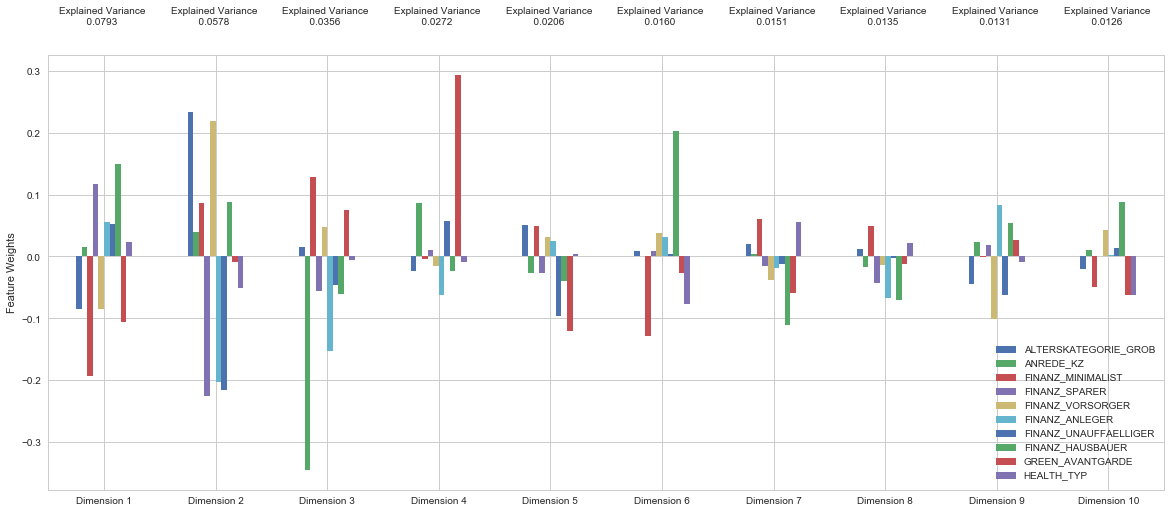

In [421]:
# Dimension indexing
dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round([pca.components_[ind][:10] for ind in range(len(pca.components_))], 4), columns = scaled_df.columns[:10])
components.index = dimensions

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = dimensions

# Create a bar plot visualization
fig, ax = plt.subplots(figsize = (20,8))

# Plot the feature weights as a function of the components
components.plot(ax = ax, kind = 'bar');
ax.set_ylabel("Feature Weights")
ax.set_xticklabels(dimensions, rotation=0)


# Display the explained variance ratios
for i, ev in enumerate(pca.explained_variance_ratio_):
    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))


## Discussion 2.3: Interpret Principal Components

* Yes, we can interpret positive and negative values from principal component, here we should concentrate on largest positive values as well as those that have the largest negative values, Two features with opposite signs are negatively associated: when one feature moves in a direction, the other feature will be expected to move in the opposite direction


* The maximum magnitude of weight indicates that is the feature which is driving the principal component or latent eighen vector.

**Latent Variables are the hidden variables which we can interpret, here the latent variables which mostly driving the importance are 1) population density -- got by interpreting buildings with family capacity. 2) Affluence 3)Personality 4) Demographics like age and gender.**

* 1) PLZ8_ANTG3 and PLZ_ANTG4, which indicate general prevalence of buildings with larger family capacity.PLZ_ANTG1 and KBA05_ANTG1, which indicate the prevalence of buildings with smaller family capacity. This suggests that this feature says something about **Population** volume.


* 2) FINANZ_* variables, HH_EINKOMMEN_SCORE, REGIOTYP, ARBEIT, RELAT_AB these variables with highest magnitude of weights, I interpreted as this variables are trying to describe Latent variable **Affluence**.


* MOBI_REGIO is tangentially related, with smaller values indicating higher movement rates. These higher movement rates appear to correspond with **People in higher-density communities or with lower affluence**.


* SEMIO_ variables weights are saying about outlook which is corelated with the cost of living of people by which I derived the latent variable **Personality and outlook**.


* ALTERSKATEGORIE_GROB variables weights engineered from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 weights are of higher magnitude which helped me to interpret latent variable which include demographics **Age associations**


* ANREDE_KZ variable weights are of higher magnitude which is negative influnences the factor of **Gender** in demographics.


* Note: Here the **magnitude matters more irrespective of sign**, Sign only helps in interpreting the correlation either positive/negative.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. The largest value you should test should be at least 10 clusters, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [432]:
from sklearn.cluster import KMeans
kmeans_avg=[]
kmeans_res_li=[]
# Over a number of different cluster counts...
for ind in range(2,16):
    # run k-means clustering on the data and...
    print('For Cluster',ind,'Processing is going on')
    kmeans=KMeans(n_clusters=ind, random_state=0)
    res_kmeans=kmeans.fit_predict(principalComponents_updated)
    kmeans_res_li.append(res_kmeans)
    # compute the average within-cluster distances.
    kmeans_avg.append((kmeans.score(principalComponents_updated)/len(principalComponents_updated))*-1)

For Cluster 2 Processing is going on
For Cluster 3 Processing is going on
For Cluster 4 Processing is going on
For Cluster 5 Processing is going on
For Cluster 6 Processing is going on
For Cluster 7 Processing is going on
For Cluster 8 Processing is going on
For Cluster 9 Processing is going on
For Cluster 10 Processing is going on
For Cluster 11 Processing is going on
For Cluster 12 Processing is going on
For Cluster 13 Processing is going on
For Cluster 14 Processing is going on
For Cluster 15 Processing is going on


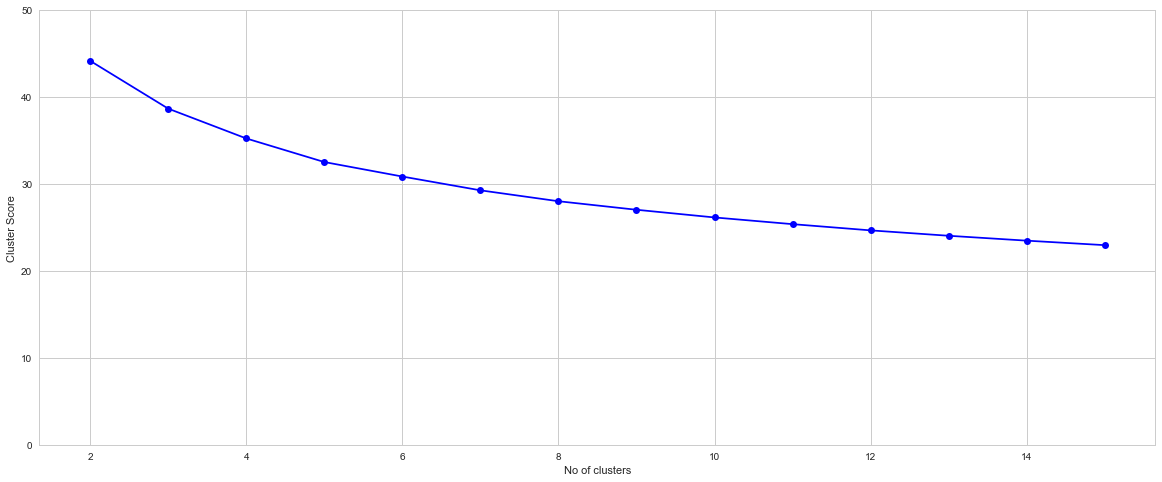

In [674]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.ylabel('Cluster Score')
plt.xlabel('No of clusters')
plt.ylim(0,50,5)
x=[0,2,4,6,8,10,12,14]
my_xticks=[2,4,6,8,10,12,14,16]
plt.xticks(x, my_xticks)
plt.style.context('seaborn-whitegrid')
plt.plot(kmeans_avg,marker='o', color='b')

In [438]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans=KMeans(n_clusters=11, random_state=0)
res_kmeans_11=kmeans.fit_predict(principalComponents_updated)

### Discussion 3.1: Apply Clustering to General Population

* As I have observed in the above picture that after 11 clusters, score is not changing/stagnant/converged significantly so I decided to choose 11.


* I can try with 20 clusters to confirm whether this is local minima, but it is taking too much time. I think 11 should be fine

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [562]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [594]:
customers.shape

(191652, 85)

In [608]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean=clean_data(customers)
customers_clean['GEBAEUDETYP_5.0']=[0 for ind in range(len(customers_clean))]

C:\Users\TsalikiK\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\TsalikiK\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [609]:
customers_clean.shape

(140898, 192)

In [611]:
cust_imputer_df=imputer.transform(customers_clean)
cust_scaled=scaler.transform(cust_imputer_df)
cust_scaled_df=pd.DataFrame(cust_scaled, columns=list(customers_clean.columns))

In [612]:
pca_customers=pca.transform(cust_scaled)

In [613]:
kmeans_cus=kmeans.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [657]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
demo_bin = np.bincount(res_kmeans_11)
demo_dict={}
for ind in range(11):
    demo_dict[ind]=demo_bin[ind]*100/len(azdias)
demo_dict[-1]=(len(azdias)-len(azdias_drop_one_hot))*100/len(azdias)

In [659]:
cust_bin = np.bincount(kmeans_cus)
cust_dict={}
for ind in range(11):
    cust_dict[ind]=cust_bin[ind]*100/len(customers)
cust_dict[-1]=(len(customers)-len(customers_clean))*100/len(customers)

<Container object of 12 artists>

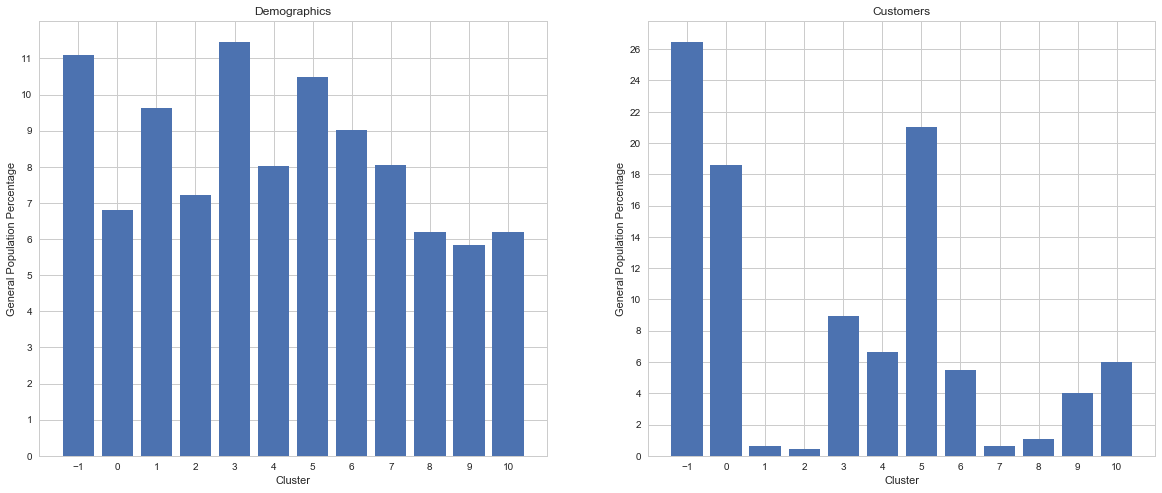

In [662]:
plt.rcParams["figure.figsize"] = (20,8)
plt.subplot(1,2,1)
plt.ylabel('General Population Percentage')
plt.xlabel('Cluster')
plt.xticks(np.arange(-1,11))
plt.yticks(np.arange(0,12,1))

plt.title('Demographics')
plt.bar(list(demo_dict.keys()),list(demo_dict.values()))
plt.subplot(1,2,2)
plt.ylabel('General Population Percentage')
plt.xlabel('Cluster')
plt.title('Customers')
plt.yticks(np.arange(0,30,2))
plt.xticks(np.arange(-1,11))

plt.bar(list(cust_dict.keys()),list(cust_dict.values()))

In [706]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_represented=kmeans.cluster_centers_[0]
over_represented

array([-4.39557212,  0.09900246,  3.21050223,  2.70823443, -0.68271333,
       -0.47288928, -0.71508994, -0.5783677 ,  0.09524184,  0.01228877])

In [ ]:
# Let's take the top3 componets i.e 1,3,4

In [ ]:
# Let us analyse on first principal component

In [708]:
pca_analysis(0)

Positive:  47 MOBI_REGIO 0.19657926367268597  Negative:  100 LP_STATUS_FEIN_1.0 -0.1154398843042079
Positive:  2 FINANZ_MINIMALIST 0.18668537868171675  Negative:  40 KBA05_ANTG4 -0.1154398843042079
Positive:  37 KBA05_ANTG1 0.1862112868533418  Negative:  7 FINANZ_HAUSBAUER -0.12733490354093271
Positive:  51 PLZ8_ANTG1 0.18186395644896783  Negative:  43 EWDICHTE -0.1333279542193575
Positive:  41 KBA05_GBZ 0.17598565188836843  Negative:  58 ORTSGR_KLS9 -0.13654932337393652
Positive:  34 KONSUMNAEHE 0.15466624804166393  Negative:  54 PLZ8_ANTG4 -0.18135155681035287
Positive:  56 PLZ8_GBZ 0.153374641333079  Negative:  53 PLZ8_ANTG3 -0.18281699351456243
Positive:  44 INNENSTADT 0.14949675136019153  Negative:  191 CAMEO_INTL_2015_WEALTH -0.1894379192092653
Positive:  109 LP_STATUS_FEIN_10.0 0.1300171753079438  Negative:  29 HH_EINKOMMEN_SCORE -0.1924045475870981
Positive:  114 LP_STATUS_GROB_5.0 0.12739935163144045  Negative:  110 LP_STATUS_GROB_1.0 -0.20538272647105013


In [713]:
# Optional for my cross checking
pca_inverse=pca.inverse_transform(pca_customers)
scaler_inverse=scaler.inverse_transform(pca_inverse[0])
scaler_inverse[[47,2,37,100,40,7]]

array([3.73361954, 4.70284674, 2.45351305, 0.28006075, 0.18242829,
       2.8892126 ])

In [ ]:
# Note 

# Here I observe that FINANZ_MINIMALIST which is Financial **typology** and I observed in the both the data there is 
# clear difference between count of people. Most of the data given consist from segment high.

In [ ]:
# Let us analyse third principal component

In [714]:
pca_analysis(2)

Positive:  1 ANREDE_KZ 0.31895532530335347  Negative:  14 SEMIO_MAT -0.07969461245947494
Positive:  22 SEMIO_KAEM 0.2603727059201742  Negative:  13 SEMIO_REL -0.09328888536807407
Positive:  21 SEMIO_DOM 0.25718830569533513  Negative:  122 ZABEOTYP_1 -0.10028628230682814
Positive:  20 SEMIO_KRIT 0.25107428323260006  Negative:  118 SHOPPER_TYP_0.0 -0.15342326517391766
Positive:  17 SEMIO_ERL 0.13555058117087923  Negative:  2 FINANZ_MINIMALIST -0.15442119244612162
Positive:  19 SEMIO_RAT 0.1289104366548458  Negative:  70 FINANZTYP_5 -0.20764972775813642
Positive:  5 FINANZ_ANLEGER 0.12303322332365149  Negative:  18 SEMIO_KULT -0.2663169870916891
Positive:  66 FINANZTYP_1 0.11658839880792074  Negative:  11 SEMIO_SOZ -0.28322108492165576
Positive:  120 SHOPPER_TYP_2.0 0.11333450557342688  Negative:  12 SEMIO_FAM -0.3150721662802404
Positive:  101 LP_STATUS_FEIN_2.0 0.08871131027242685  Negative:  15 SEMIO_VERT -0.3449260728484117


In [715]:
# Optional for my cross checking
scaler_inverse[[1,22,21,14,13,122]]

array([0.93916967, 1.95619271, 2.31710141, 3.2184451 , 3.41585013,
       0.48434489])

In [725]:
# Note

# Here in this segment is about Personality typology as I observed there is clear change in distibution of the data **affinity**

In [ ]:
# Let us analyse fourth principal component

In [716]:
pca_analysis(3)

Positive:  188 PRAEGENDE_JUGENDJAHRE_MOVEMENT 0.29362584734132086  Negative:  99 LP_FAMILIE_GROB_5.0 -0.13294636295599863
Positive:  113 LP_STATUS_GROB_4.0 0.2436546067159681  Negative:  22 SEMIO_KAEM -0.14438007856681215
Positive:  108 LP_STATUS_FEIN_9.0 0.2436546067159681  Negative:  48 ONLINE_AFFINITAET -0.14438007856681215
Positive:  42 BALLRAUM 0.2105835392489269  Negative:  21 SEMIO_DOM -0.15728242519180854
Positive:  44 INNENSTADT 0.20577184776908944  Negative:  27 ANZ_PERSONEN -0.16209110372335014
Positive:  46 KKK 0.13718534401831228  Negative:  58 ORTSGR_KLS9 -0.17131118993215597
Positive:  29 HH_EINKOMMEN_SCORE 0.1272429688708572  Negative:  43 EWDICHTE -0.17390001906166133
Positive:  84 LP_FAMILIE_FEIN_1.0 0.12037077440354789  Negative:  109 LP_STATUS_FEIN_10.0 -0.1848991488523347
Positive:  95 LP_FAMILIE_GROB_1.0 0.11594474039166909  Negative:  114 LP_STATUS_GROB_5.0 -0.19575541944806985
Positive:  103 LP_STATUS_FEIN_4.0 0.11565876714232458  Negative:  8 GREEN_AVANTGARDE -

In [717]:
# Optional for my cross checking
scaler_inverse[[118,113,108,99,22,48]]

array([0.42434359, 0.20744729, 0.21957145, 0.08254808, 1.95619271,
       2.18608518])

In [726]:
# Note

# Here also affinity is what differentiating that is online affinity described by variable ONLINE_AFFINITAET 

In [707]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_represented=kmeans.cluster_centers_[1]
under_represented

array([ 5.25286322, -1.85192881, -2.27324662,  0.84793828,  0.07154774,
       -0.37461402, -0.19133713, -0.47473908,  0.13199883,  0.44675884])

In [ ]:
# Let's take the top3 componets i.e 1,3,2

In [718]:
# Let us analyse fist principal component

In [719]:
pca_analysis(0)

Positive:  47 MOBI_REGIO 0.19657926367268597  Negative:  100 LP_STATUS_FEIN_1.0 -0.1154398843042079
Positive:  2 FINANZ_MINIMALIST 0.18668537868171675  Negative:  40 KBA05_ANTG4 -0.1154398843042079
Positive:  37 KBA05_ANTG1 0.1862112868533418  Negative:  7 FINANZ_HAUSBAUER -0.12733490354093271
Positive:  51 PLZ8_ANTG1 0.18186395644896783  Negative:  43 EWDICHTE -0.1333279542193575
Positive:  41 KBA05_GBZ 0.17598565188836843  Negative:  58 ORTSGR_KLS9 -0.13654932337393652
Positive:  34 KONSUMNAEHE 0.15466624804166393  Negative:  54 PLZ8_ANTG4 -0.18135155681035287
Positive:  56 PLZ8_GBZ 0.153374641333079  Negative:  53 PLZ8_ANTG3 -0.18281699351456243
Positive:  44 INNENSTADT 0.14949675136019153  Negative:  191 CAMEO_INTL_2015_WEALTH -0.1894379192092653
Positive:  109 LP_STATUS_FEIN_10.0 0.1300171753079438  Negative:  29 HH_EINKOMMEN_SCORE -0.1924045475870981
Positive:  114 LP_STATUS_GROB_5.0 0.12739935163144045  Negative:  110 LP_STATUS_GROB_1.0 -0.20538272647105013


In [720]:
# Optional for my cross checking
scaler_inverse[[47,2,37,100,40,7]]

array([3.73361954, 4.70284674, 2.45351305, 0.28006075, 0.18242829,
       2.8892126 ])

In [ ]:
# Note: Mobi_Regio is the variable which influencing here, It is tangentially related, with smaller values indicating higher movement rates. These higher movement rates appear to correspond with people in higher-density communities or with lower affluence.

In [ ]:
# Let us analyse second principal component

In [721]:
pca_analysis(1)

Positive:  189 PRAEGENDE_JUGENDJAHRE_INTERVAL 0.23292514202740927  Negative:  100 LP_STATUS_FEIN_1.0 -0.16276794903307074
Positive:  3 FINANZ_SPARER 0.21865767431960842  Negative:  70 FINANZTYP_5 -0.16497257328761586
Positive:  6 FINANZ_UNAUFFAELLIGER 0.20036573829239537  Negative:  61 CJT_GESAMTTYP_2.0 -0.16793376803634913
Positive:  13 SEMIO_REL 0.18035946029411362  Negative:  30 W_KEIT_KIND_HH -0.20314654925953624
Positive:  24 SEMIO_TRADV 0.16365577111205182  Negative:  10 RETOURTYP_BK_S -0.20487537211960288
Positive:  23 SEMIO_PFLICHT 0.15609694045760691  Negative:  16 SEMIO_LUST -0.20806449302782773
Positive:  5 FINANZ_ANLEGER 0.12801653733859908  Negative:  17 SEMIO_ERL -0.2137405867266505
Positive:  19 SEMIO_RAT 0.10799268233449076  Negative:  124 ZABEOTYP_3 -0.21487110848236027
Positive:  18 SEMIO_KULT 0.09784698188994383  Negative:  4 FINANZ_VORSORGER -0.22612164005398097
Positive:  48 ONLINE_AFFINITAET 0.09746569732524818  Negative:  0 ALTERSKATEGORIE_GROB -0.238003795672038

In [722]:
# Optional for my cross checking
scaler_inverse[[189,3,6,100,5,61]]

array([2.22626551, 0.77612017, 1.84917587, 0.28006075, 0.62436246,
       0.42083575])

In [727]:
# Note

# Here PRAEGENDE_JUGENDJAHRE on which Interval is causing a difference between two datasets sample sizes of those two are different

In [ ]:
# Let us analyse third principal component

In [723]:
pca_analysis(2)

Positive:  1 ANREDE_KZ 0.31895532530335347  Negative:  14 SEMIO_MAT -0.07969461245947494
Positive:  22 SEMIO_KAEM 0.2603727059201742  Negative:  13 SEMIO_REL -0.09328888536807407
Positive:  21 SEMIO_DOM 0.25718830569533513  Negative:  122 ZABEOTYP_1 -0.10028628230682814
Positive:  20 SEMIO_KRIT 0.25107428323260006  Negative:  118 SHOPPER_TYP_0.0 -0.15342326517391766
Positive:  17 SEMIO_ERL 0.13555058117087923  Negative:  2 FINANZ_MINIMALIST -0.15442119244612162
Positive:  19 SEMIO_RAT 0.1289104366548458  Negative:  70 FINANZTYP_5 -0.20764972775813642
Positive:  5 FINANZ_ANLEGER 0.12303322332365149  Negative:  18 SEMIO_KULT -0.2663169870916891
Positive:  66 FINANZTYP_1 0.11658839880792074  Negative:  11 SEMIO_SOZ -0.28322108492165576
Positive:  120 SHOPPER_TYP_2.0 0.11333450557342688  Negative:  12 SEMIO_FAM -0.3150721662802404
Positive:  101 LP_STATUS_FEIN_2.0 0.08871131027242685  Negative:  15 SEMIO_VERT -0.3449260728484117


In [724]:
# Optional for my cross checking
scaler_inverse[[1,22,21,14,13,122]]

array([0.93916967, 1.95619271, 2.31710141, 3.2184451 , 3.41585013,
       0.48434489])

In [728]:
# Note

# Same here also affinity is what causing the difference that is SEMIO_REL.

## Discussion 3.3: Compare Customer Data to Demographics Data

* Hi, Here on the above observations I observed the cluster lengths were different, that means the significance between is low between them. After inspecting clearly, I found that segments which correspond to **Affinity, Typology, Demographics are playing significant role in that difference**, So I go for the low.


* My points after interpreting **Over represented cluster**, I have gone through top 3 principal components that were 1,3,4

    * After Interpreting first principal component I got to know that maximum magnitude weight is talking about Financial typology, Here I observe that FINANZ_MINIMALIST which is **Financial typology** and I observed in the both the data there is clear difference between count of people. Most of the data given consist from high segment.
    
    * After interpreting third principal component I got to know that maximum magnitude weight is talking about Affinity, Here in this segment is about Personality typology as I observed there is clear change in distibution of the data **Affinity**.
       
    * After interpreting fourth principal component I got to know that maximum magnitude weight is talking about Online Affinity, Here also affinity is what differentiating that is online affinity described by variable **ONLINE_AFFINITAET**.
    
    
* My points after interpreting **Under represented cluster**, I have gone through top 3 principal components that were 1,3,2

    * After interpreting the first principal component I got to know that, Mobi_Regio is the variable which influencing here, It is tangentially related, with **smaller values indicating higher movement rates**. These higher movement rates appear to correspond with people in higher-density communities or with lower affluence. Also I got to know that maximum magnitude weight is talking about Financial typology, Here I observe that FINANZ_MINIMALIST which is **Financial typology** and I observed in the both the data there is clear difference between count of people. Most of the data given consist from high segment.
    
    * After interpreting the third principal component, I got to know that maximum magnitude weight is talking about Affinity, Here in this segment is about Personality typology as I observed there is clear change in distibution of the data **Affinity**.
        
    * After interpreting second principal component, I got to know that maximum magnitude weight is talking about demographics **Age/Year Interval**,Here PRAEGENDE_JUGENDJAHRE on which Interval is causing a difference between two datasets sample sizes of those two are different, Also it is indicating about the difference in **Financial typology**.
    
** Comparision and interpreting two different cluster distibution of two datasets**    
    
* The Customers data has low relativity most of the data is concentrated in urban areas or with high Financial typology.
    
    
** To summarize the overall interpretation, I can conclude by saying there is clear difference in the sample distibution of two datasets in following factors/latent variables Financial typology, Affinity, Population Density and Demographics. One cluster with customers dataset has the samples with higher Financial typology and lower movement rates and High affinity towards the cost of living. The Demographics data has a mix of all people in Financial typology, Affinity, Population Density and Demographics, that is the reason you can see the very well disributed clusters in the demographics dataset.**





 
    


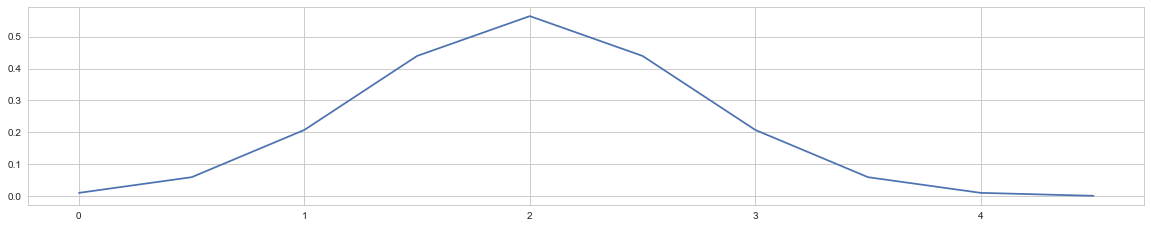

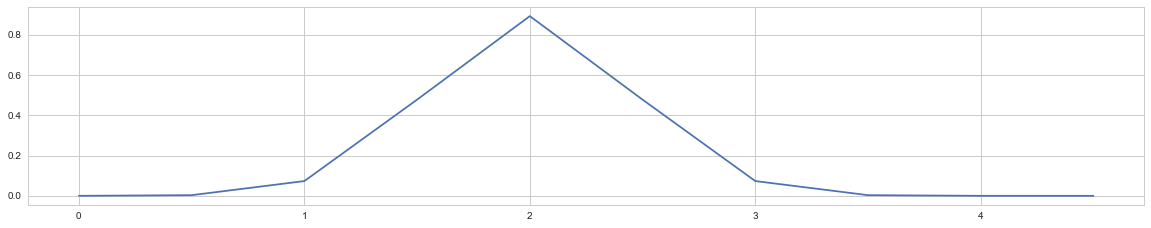

In [739]:
# Sampling distibution of Demographics Dataset and Customers Dataset

import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Clusters
x = np.linspace(0, 5, 10, endpoint=False)

# Demographics data exactly at cluster two it takes maximum that is 50 perecent of Financial topology samples fall here
y = multivariate_normal.pdf(x, mean=2, cov=0.5); 
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax1.plot(x, y)

# Customers data exactly at cluster two it takes maximum that is 80 perecent of Financial topology samples fall here
fig2= plt.figure()
ax2 = fig2.add_subplot(212)
x = np.linspace(0, 5, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=2, cov=0.2); 
ax2.plot(x, y)
# You can see clear distribution in plot I got values by manual intervention and I want to visualize it.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.